In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
import torch
import torch.nn as nn
import tqdm.notebook as tqdm
import copy

CONSTANTS = namedtuple('CONSTANTS', ['STARTING_KAPPA_VALUE', 'ENDING_KAPPA_VALUE', 
                                     'NUMBER_OF_STEPS', 'STEP_SIZE', 'DEBUGGING', 'LATTICE_SHAPE', 
                                     'NUMBER_OF_MODELS'])

constants = CONSTANTS(0.24, 0.3, 24, (0.3 - 0.24) / 24, False, (16,16), 4)

dt = 0.1
n_steps = 10

In [5]:
torch.set_default_dtype(torch.float64)

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    torch_device = 'cuda'
    torch.set_default_device(torch_device)
else:
    torch_device = 'cpu'
    torch.set_default_device(torch_device)

float_dtype = np.float64
print(f"TORCH DEVICE: {torch_device}")

def grab(var):
    return var.detach().cpu().numpy()

TORCH DEVICE: cpu


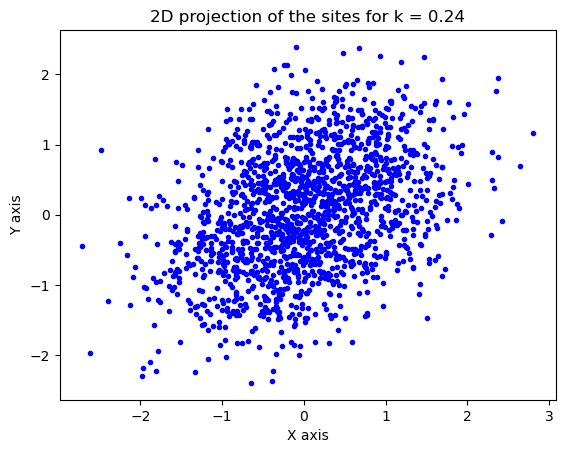

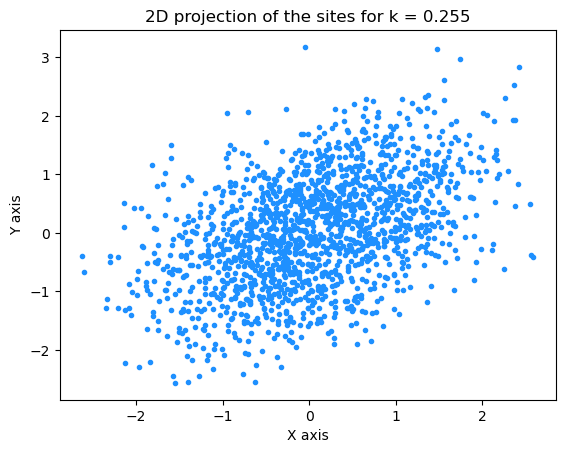

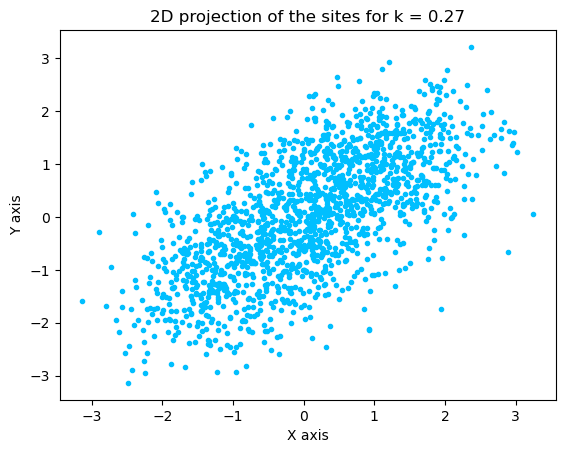

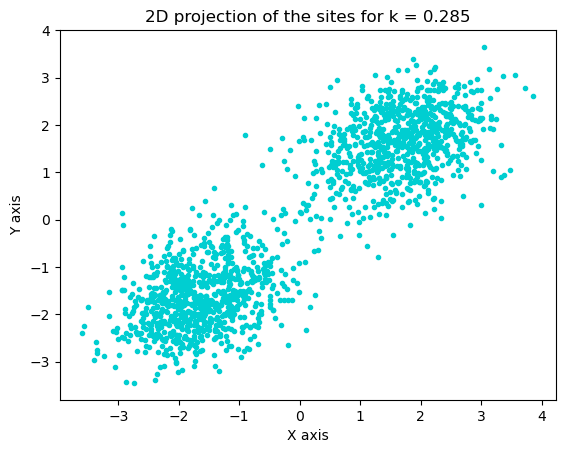

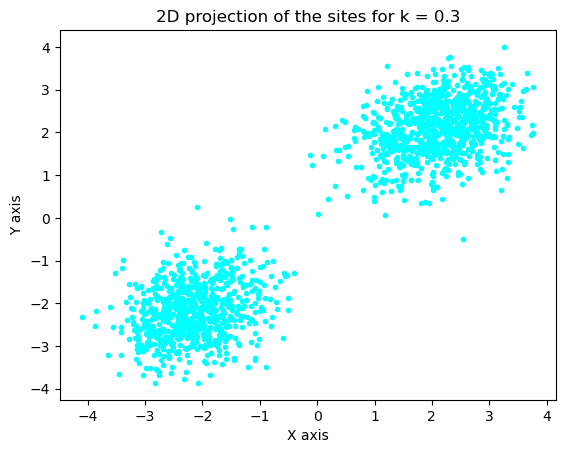

In [6]:
# Lattice diagrams

training_set = np.load('lattice_train.npy')
test_set = np.load('lattice_test.npy')
colors = ["blue", "dodgerblue", "deepskyblue", "darkturquoise", "aqua"]

i = 0
while i <= 4:    
    current_color = colors[i]

    if i == 0:
        lattice_sites = test_set[0]
    else:
        lattice_sites = test_set[(i * 6) - 1];

    if constants.DEBUGGING:
        print(i * 6)
    
    for lattice_site in lattice_sites:
        feature1 = lattice_site[:, 0]
        feature2 = lattice_site[:, 1]
        plt.scatter(feature1, feature2, marker=".", color=current_color)
        plt.title('2D projection of the sites for k = ' 
                  + str((constants.STEP_SIZE * i * 6) + constants.STARTING_KAPPA_VALUE))
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
    
    plt.show()
    i += 1

In [7]:
# MARKDOWN EXPLANATION OF THE ABOVE

In [8]:
def hmc(
        phi: torch.Tensor,
        action_fn,
        force_fn,
        dt: float=0.1,
        n_steps: int=10):
    """Return batch of updated phi, acceptance rate."""
    dims = [i+1 for i in range(len(phi.shape)-1)]
    S = action_fn(phi)

    new_phi = copy.deepcopy(phi)
    momentum = torch.randn(phi.shape)
    hamiltonian = 0.5 * torch.sum(momentum**2, dims) + S

    momentum += 0.5 * dt * force_fn(new_phi)
    for _ in range(n_steps-1):
        new_phi += dt * momentum
        momentum += dt * force_fn(new_phi)
    new_phi += dt * momentum
    momentum += 0.5 * dt * force_fn(new_phi)

    new_S = action_fn(new_phi)
    d_hamiltonian = 0.5 * torch.sum(momentum**2, dims) + new_S - hamiltonian

    accept = torch.rand(len(d_hamiltonian)) < torch.exp(-d_hamiltonian)
    a = accept.view(-1,1,1).repeat(1,*phi.shape[1:])

    return a * new_phi + ~a * phi, accept

In [9]:
def run_hmc(
        n_iter: int,
        phi: torch.Tensor,
        hmc_fn,
        verbose: bool=True):
    if verbose:
        accept_rate = 0
        trange = tqdm.trange(n_iter)
        for i in trange:
            phi, accept = hmc_fn(phi)
            accept_rate += np.mean(grab(accept))
            trange.set_postfix(acc=str(np.round(accept_rate / (i+1), 2)))
        print(f"\nacceptance rate: {accept_rate / n_iter}")
    else:
        for i in range(n_iter):
            phi, _ = hmc_fn(phi)

    return phi

In [10]:
def calc_action(
        phi: torch.Tensor,
        kap: float,
        lam: float,
        h: float):
    dims = [i+1 for i in range(len(phi.shape)-1)]
    action = (1 - 2 * lam) * phi**2 + lam * phi**4 + h * phi
    action += -2. * kap * phi * torch.roll(phi, 1, 1)
    action += -2. * kap * phi * torch.roll(phi, 1, 2)

    return torch.sum(action, dims)

def calc_force(
        phi: torch.Tensor,
        kap: float,
        lam: float,
        h: float):
    dims = [i+1 for i in range(len(phi.shape)-1)]
    force = 2 * phi * (2 * lam * (1 - phi**2) - 1) - h
    force += 2. * kap * (torch.roll(phi, 1, 1) + torch.roll(phi, -1, 1))
    force += 2. * kap * (torch.roll(phi, 1, 2) + torch.roll(phi, -1, 2))

    return force

In [11]:
batch_size = 1000

# below phase transition (symmetric/disordered phase)

kap = 0.24
lam = 0.02
h = 0.0

symmetric_phase_data = run_hmc(
    n_iter=1000,
    phi=0.1 * torch.randn(batch_size, *constants.LATTICE_SHAPE),
    hmc_fn=lambda phi: hmc(
        phi=phi,
        action_fn=lambda phi: calc_action(phi, kap, lam, h),
        force_fn=lambda phi:calc_force(phi, kap, lam, h),
        dt=dt,
        n_steps=n_steps))

# above phase transition (broken/ordered phase)

kap = 0.3
lam = 0.02
h = 0.0

broken_phase_data = run_hmc(
    n_iter=1000,
    phi=0.1 * torch.randn(batch_size, *constants.LATTICE_SHAPE),
    hmc_fn=lambda phi: hmc(
        phi=phi,
        action_fn=lambda phi: calc_action(phi, kap, lam, h),
        force_fn=lambda phi: calc_force(phi, kap, lam, h),
        dt=dt,
        n_steps=n_steps))

  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9644190000000015


  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9529009999999992


In [12]:
batch_size = 100

# equidistant points crossing the phase boundary

kaps = [0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.30]
lam = 0.02
h = 0.0

eval_data = []

for kap in kaps:
    eval_data.append(run_hmc(
        n_iter=1000,
        phi=0.1 * torch.randn(batch_size, *constants.LATTICE_SHAPE),
        hmc_fn=lambda phi: hmc(
            phi=phi,
            action_fn=lambda phi: calc_action(phi, kap, lam, h),
            force_fn=lambda phi:calc_force(phi, kap, lam, h),
            dt=dt,
            n_steps=n_steps)))

  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9636100000000138


  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9643600000000128


  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9622300000000121


  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9607100000000119


  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9566500000000127


  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9549800000000102


  0%|          | 0/1000 [00:00<?, ?it/s]


acceptance rate: 0.9532600000000108


In [13]:
# Design the Convolutional neural network for the problem
class Net(torch.nn.Module):
    def __init__(self, lattice_shape):
        super().__init__()
        kernel_size = 3
        self.lattice_shape = lattice_shape
        self.cnn = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 16, kernel_size, padding=1, padding_mode='circular'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 16, kernel_size, padding=1, padding_mode='circular'),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 1, kernel_size, padding=1, padding_mode='circular')])
        self.mlp = torch.nn.ModuleList([
            torch.nn.Linear(np.prod(lattice_shape), np.prod(lattice_shape)),
            torch.nn.ReLU(),
            torch.nn.Linear(np.prod(lattice_shape), 1),
            torch.nn.Sigmoid()])

    def forward(self, x):
        x = x[:,None]
        for layer in self.cnn:
            x = layer(x)
        x = x.flatten(1)
        for layer in self.mlp:
            x = layer(x)
        return x.flatten()

  0%|          | 0/100 [00:00<?, ?it/s]

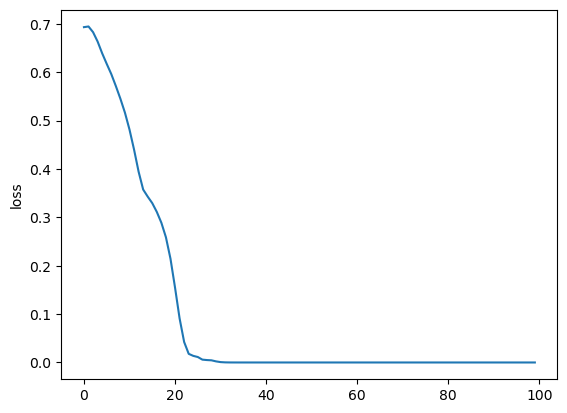

In [14]:
net = Net(constants.LATTICE_SHAPE)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

training_data = torch.concatenate(
    [symmetric_phase_data, broken_phase_data])
training_labels = torch.concatenate(
    [torch.zeros(len(symmetric_phase_data)),
     torch.ones(len(broken_phase_data))])

loss_vals = []
for _ in tqdm.tqdm(range(100)):
    optimizer.zero_grad()
    out = net(training_data)
    loss = loss_fn(out, training_labels)
    loss.backward()
    optimizer.step()
    loss_vals.append(loss.item())

plt.ylabel('loss')
plt.plot(loss_vals)

In [15]:
mean_preds, std_preds = [], []
with torch.no_grad():
    for data in eval_data:
        preds = net(data)
        mean_preds.append(preds.mean().item())
        std_preds.append(preds.std().item())

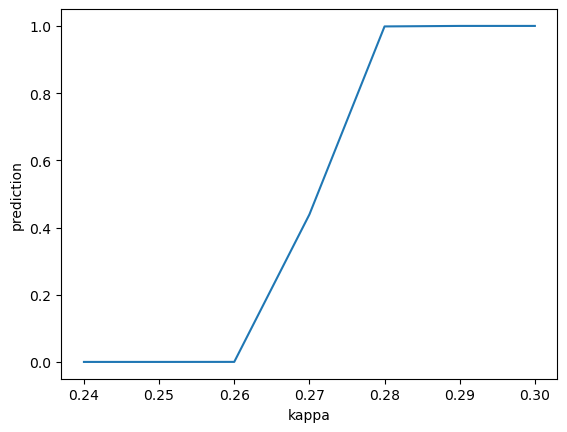

In [16]:
plt.xlabel('kappa')
plt.ylabel('prediction')
plt.plot(kaps, mean_preds)

As shown in the graph below the cricial value for $\kappa$ is 0.27, if we compare this to the graphs that we generated before for values of &k we note that the lattice is at the breaking limit, infact if we increase its value ever so slightly we can see the first signs of rupture of the reticle.

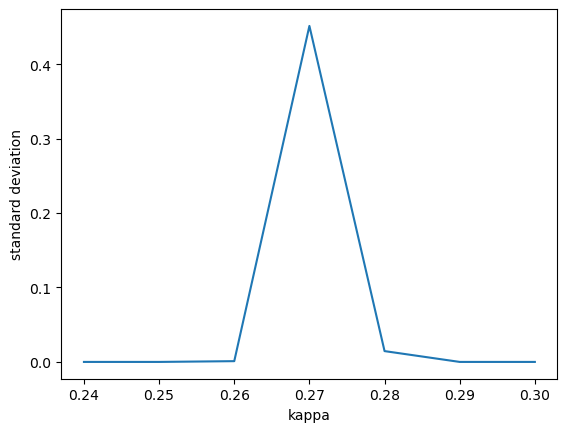

In [17]:
plt.xlabel('kappa')
plt.ylabel('standard deviation')
plt.plot(kaps, std_preds)

For reference look at the graphs below:

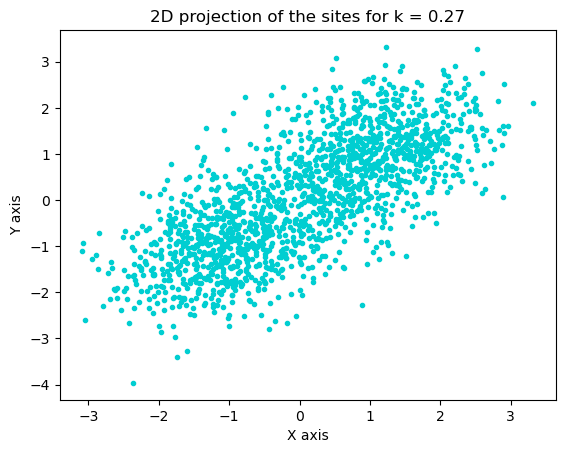

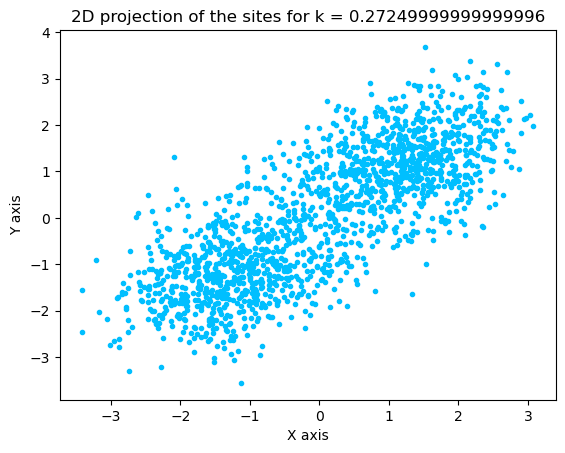

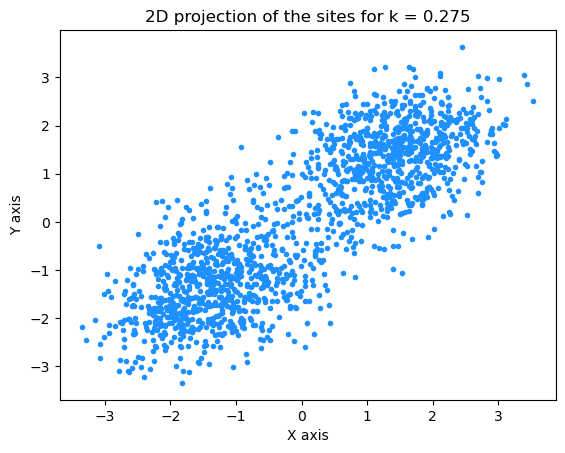

In [18]:
for i in [12, 13, 14]:
    lattice_sites = test_set[i];
    for lattice_site in lattice_sites:
        feature1 = lattice_site[:, 0]
        feature2 = lattice_site[:, 1]
        plt.scatter(feature1, feature2, marker=".", color=colors[15%i])
        plt.title('2D projection of the sites for k = ' 
                  + str((constants.STEP_SIZE * i) + constants.STARTING_KAPPA_VALUE))
        plt.xlabel('X axis')
        plt.ylabel('Y axis')
    
    plt.show()

In [19]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")

  1% [.                                                                       ]  1097728 / 55093854

  4% [...                                                                     ]  2588672 / 55093854

  7% [.....                                                                   ]  4046848 / 55093854

  9% [.......                                                                 ]  5472256 / 55093854

 12% [.........                                                               ]  6897664 / 55093854

 15% [..........                                                              ]  8273920 / 55093854

 17% [............                                                            ]  9789440 / 55093854

 19% [.............                                                           ] 10649600 / 55093854

 22% [...............                                                         ] 12132352 / 55093854

 26% [...................                                                     ] 14663680 / 55093854

 29% [.....................                                                   ] 16105472 / 55093854

 31% [......................                                                  ] 17465344 / 55093854

 34% [........................                                                ] 19038208 / 55093854

 37% [..........................                                              ] 20463616 / 55093854

 39% [............................                                            ] 21897216 / 55093854

 42% [..............................                                          ] 23330816 / 55093854

 44% [................................                                        ] 24764416 / 55093854

 47% [..................................                                      ] 26198016 / 55093854

 50% [....................................                                    ] 27631616 / 55093854

 52% [.....................................                                   ] 29065216 / 55093854

 55% [.......................................                                 ] 30490624 / 55093854

 57% [.........................................                               ] 31940608 / 55093854

 60% [...........................................                             ] 33374208 / 55093854

 63% [.............................................                           ] 34799616 / 55093854

 65% [...............................................                         ] 36184064 / 55093854

 68% [.................................................                       ] 37675008 / 55093854

 70% [...................................................                     ] 39084032 / 55093854

 73% [....................................................                    ] 40476672 / 55093854

 76% [......................................................                  ] 41967616 / 55093854

 78% [........................................................                ] 43401216 / 55093854

 81% [..........................................................              ] 44843008 / 55093854

 83% [............................................................            ] 46276608 / 55093854

 86% [..............................................................          ] 47710208 / 55093854

 89% [................................................................        ] 49135616 / 55093854

 91% [..................................................................      ] 50561024 / 55093854

 94% [...................................................................     ] 51994624 / 55093854

 96% [.....................................................................   ] 53436416 / 55093854

 99% [....................................................................... ] 54853632 / 55093854

100% [........................................................................] 55093854 / 55093854

100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 23.03it/s]


In [20]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


In [21]:
class amp_net(nn.Module):
    
    def __init__(self, hdn_dim=32, ipt_dim=20, opt_dim=1, n_layers=2):
        super(amp_net, self).__init__()
        
        assert n_layers>=2
        
        layers = []
        layers.append(nn.Linear(ipt_dim, hdn_dim))
        layers.append(nn.ReLU())
        for _ in range(n_layers-2):
            layers.append(nn.Linear(hdn_dim, hdn_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hdn_dim, opt_dim))
        
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [22]:
# flatten datasets
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

In [23]:
def preprocess_x(x_in, mean=None, std=None):
    x = x_in.copy() # do not overwrite
    if mean is None or std is None:
        mean = x.mean(keepdims=True)
        std = x.std(keepdims=True)
    x = (x - mean) / std # standardize
    assert np.isfinite(x).all() # check for nans and infs
    return torch.Tensor(x).float(), mean, std # create torch tensors
    
def preprocess_A(A_in, mean=None, std=None):
    A = A_in.copy()
    A = np.log(A)
    if mean is None or std is None:
        mean = A.mean(keepdims=True)
        std = A.std(keepdims=True)
    A = (A - mean) / std
    assert np.isfinite(A).all() 
    return torch.tensor(A).float().unsqueeze(-1), mean, std

def undo_preprocess_A(A_in, mean, std):
    A = A_in.copy()
    A = A * std + mean
    A = np.exp(A)
    return A

In [24]:
class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]

In [25]:
# create datasets and dataloaders
trn_datfp, mean_x, std_x = preprocess_x(trn_datf)
val_datfp, _, _ = preprocess_x(val_datf, mean_x, std_x)
tst_datfp, _, _ = preprocess_x(tst_datf, mean_x, std_x)

trn_ampp, mean_A, std_A = preprocess_A(trn_amp)
val_ampp, _, _ = preprocess_A(val_amp, mean_A, std_A)
tst_ampp, _, _ = preprocess_A(tst_amp, mean_A, std_A)

trn_dataset = amp_dataset(trn_datfp, trn_ampp)
val_dataset = amp_dataset(val_datfp, val_ampp)
tst_dataset = amp_dataset(tst_datfp, tst_ampp)

batch_size = 64
trn_dataloader = torch.utils.data.DataLoader(trn_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
tst_dataloader = torch.utils.data.DataLoader(tst_dataset, batch_size=batch_size, shuffle=False)

In [26]:
x, A = next(iter(trn_dataloader))
print(x.shape, A.shape)

torch.Size([64, 20]) torch.Size([64, 1])


In [33]:
def training_function(model, hidden_layer, layer):
    niterations = 10000
    loss_fn = nn.MSELoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    for it in range(niterations):
        optimizer.zero_grad()

        pred = model(x)
        loss = loss_fn(pred, A)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    plt.title(f"Losses for: {hidden_layer}, {layer}")
    plt.plot(range(niterations), losses)
    plt.show()

In [34]:
def batch_loss(model, x, y):
    loss_fn = nn.MSELoss()
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    return loss

In [35]:
def evaluate(model, hidden_layer, layer):
    loss_fn = nn.MSELoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = []
    # calculate predictions
    predsp = np.array([])
    with torch.no_grad():
        for x, y in tst_dataloader:
            pred = model(x)
            predsp = np.append(predsp, pred)

    # undo preprocessing
    preds = undo_preprocess_A(predsp, mean_A, std_A)
    real_mean = np.mean(np.log(tst_amp))
    preds_means = np.mean(np.log(preds), axis=0)
    preds_stds = np.std(np.log(preds), axis=0)

    plt.hist(np.log(tst_amp), range=(-20, -8), bins=50, alpha=.5, label="test")
    plt.hist(np.log(preds), alpha=.5, range=(-20, -8), bins=50, label="predicted")
    plt.axvline(x=preds_means, color='red', linestyle='--', label='predicted mean')
    plt.axvline(x=real_mean, color='purple', linestyle='--', label='dataset mean')
    plt.xlabel(r"$\log A$")
    plt.ylabel("bin height")
    plt.legend()
    plt.show()

    x = range(len(tst_amp))
    plt.fill_between(x, preds_stds, -preds_stds, color="y", label=r"predicted $\sigma_{\log A}$")
    plt.plot(x, preds_means - np.log(tst_amp), ",", alpha=.5, ms=.1, label=r"$\log A_\mathrm{pred}-\log A_\mathrm{true}$")
    plt.xlabel("# event")
    plt.ylim(-1,1)
    plt.legend()
    plt.show()
    return preds

In [39]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using {device} device")

# hidden_layers = [32, 64, 128, 256]
# layers = [3, 5, 10]
# # hidden_layers = [16, 32]
# # layers = [3, 4]

# for hidden_layer in hidden_layers:
#     for layer in layers:
#         model = amp_net(hdn_dim=hidden_layer, n_layers=layer).to(device)
#         print(model)
#         total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
#         print(f"Model has {total_parameters:d} trainable parameters")
#         training_function(model, hidden_layer, layer)
#         evaluate(model, hidden_layer, layer)

Using cpu device
amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 1761 trainable parameters


RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double